In [6]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
import random
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 1.	Hidden States and Systematic Training

Script char_rnn_classification_Project3p1_Q1.py1 implements a vanilla RNN from scratch and trains it on a set of data containing over 20 thousand last names and their respective country of origin. The number of possible countries, or classes, is 18. All of the data for this project is in the file: data.zip. Each country of origin is contained in a separate file with the corresponding last names. A diagrammatic view of the structure of the implemented RNN is as follows:
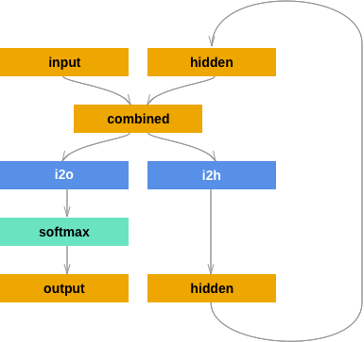
The architecture is such that the input (i.e. characters of the Last Name in this example) to the network is concatenated/stacked with the current hidden state to form a ‘combined’ stacked tensor (Refer to Lines 72-86 in the example code to see the structure of the tensors). The combined tensor is then fed through two different paths, i2h which updates the hidden state, and i2o which produces an output. Although outputs are produced at each time step, given that we are dealing with a classification task, only the output at the last time step is used.

**1.1.	(15 points)** Effect of hidden state length - run the script for hidden state sizes of 2, 8 and 32 by modifying the value of variable n_hidden. 

What is the Accuracy yielded for different hidden state sizes? Also, include a graph of the loss function and the confusion matrix for each case. 

Note that you will have to modify the existing evaluation function, as it measures accuracy from a randomly sampled population, which could lead to biased results:

for i in range(n_confusion):
category, name, category_tensor, name_tensor = randomTrainingExample()
output = evaluate(name_tensor)
guess, guess_i = categoryFromOutput(output) category_i = languages.index(category) confusion[category_i][guess_i]+= 1

You will want to measure performance on every sample in the dataset by comparing the label of the sample to the output of your trained network, and report the average accuracy.

<br><font color='SlateBlue'>*With hidden state sizes 2, the accuracy is 42.72%. 
    <br>With hidden state sizes 8, the accuracy is 48.999%.
    <br>With hidden state sizes 32, the accuracy is 58.64%.*</font>

In [7]:
def findFiles(path): return glob.glob(path)

#print(findFiles('C:/Users/*.txt'))

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#print(unicodeToAscii('Ślusàrski'))

# %%
# Build the names dictionary, a list of names per language
# di tionary keys are languages, values are names
names = {}
languages = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# PLEASE UPDATE THE FILE PATH BELOW FOR YOUR SYSTEM
for filename in findFiles(r"/Users/carolli/Desktop/Fall 2023/DSCC 275/Project-3.1/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    languages.append(category)
    lines = readLines(filename)
    names[category] = lines

n_categories = len(languages)

def findName(dict, name):
    keys = dict.keys()
    for key in keys:
        if name in dict[key]:
            return key
    return ''

findName(names,'Bernal')
findName(names,'Johnson')

# Now we have ``names``, a dictionary mapping each category
# (language) to a list of lines (names). We also kept track of
# ``languages`` (just a list of languages) and ``n_categories`` for
# later reference.
# 

#print(names['Italian'][:5])

# %% 
# Turning Names into Tensors
# --------------------------
# 
# Now that we have all the names organized, we need to turn them into
# Tensors to make any use of them.
# 
# To represent a single letter, we use a "one-hot vector" of size
# ``<1 x n_letters>``. A one-hot vector is filled with 0s except for a 1
# at index of the current letter, e.g. ``"b" = <0 1 0 0 0 ...>``.
# 
# To make a word we join a bunch of those into a 2D matrix
# ``<line_length x 1 x n_letters>``.
# 
# That extra 1 dimension is because PyTorch assumes everything is in
# batches - we're just using a batch size of 1 here.

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def nameToTensor(name):
    tensor = torch.zeros(len(name), 1, n_letters)
    for li, letter in enumerate(name):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

#print(letterToTensor('J'))

#print(nameToTensor('Jones').size())


In [8]:
# %% Creating the Network
# ====================
# 
# Before autograd, creating a recurrent neural network in Torch involved
# cloning the parameters of a layer over several timesteps. The layers
# held hidden state and gradients which are now entirely handled by the
# graph itself. This means you can implement a RNN in a very "pure" way,
# as regular feed-forward layers.
# 
# This RNN module (mostly copied from `the PyTorch for Torch users
# tutorial <https://pytorch.org/tutorials/beginner/former_torchies/
# nn_tutorial.html#example-2-recurrent-net>`__)
# is just 2 linear layers which operate on an input and hidden state, with
# a LogSoftmax layer after the output.
# 
# .. figure:: https://i.imgur.com/Z2xbySO.png
#    :alt:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

tensor([[-2.7931, -2.8759, -2.6886, -2.9451, -2.9082, -2.9245, -3.0421, -2.8272,
         -2.9179, -2.9769, -2.9343, -3.1001, -2.9403, -2.8981, -2.6845, -3.0443,
         -2.8299, -2.8041]], grad_fn=<LogSoftmaxBackward0>)
('Scottish', 14)
category = Italian / name = Tessaro
category = Scottish / name = Sinclair
category = Italian / name = Re
category = Irish / name = Desmond
category = Scottish / name = Davidson
category = Scottish / name = Bruce
category = English / name = Baron
category = Greek / name = Pefanis
category = Korean / name = Chweh
category = Chinese / name = Zhen
5000 5% (0m 1s) 3.0697 Shamoon / Irish ✗ (Arabic)
10000 10% (0m 2s) 2.0432 Ariwa / Japanese ✓
15000 15% (0m 3s) 2.5788 Bueren / Irish ✗ (Dutch)
20000 20% (0m 4s) 1.7191 Altimari / Italian ✓
25000 25% (0m 5s) 2.9704 Shi / Italian ✗ (Chinese)
30000 30% (0m 6s) 2.7034 Shi / Italian ✗ (Chinese)
35000 35% (0m 7s) 2.2846 Johnstone / French ✗ (Scottish)
40000 40% (0m 8s) 1.4580 Aida / Japanese ✓
45000 45% (0m 9s) 1.447

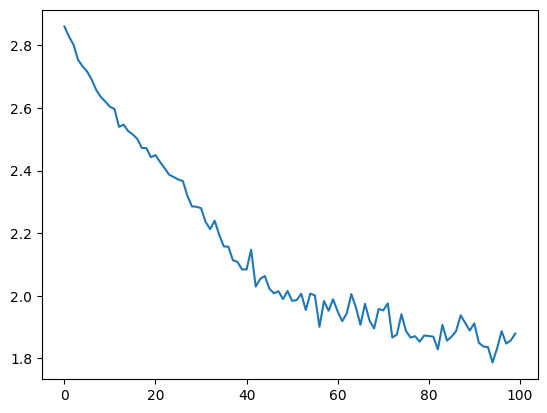

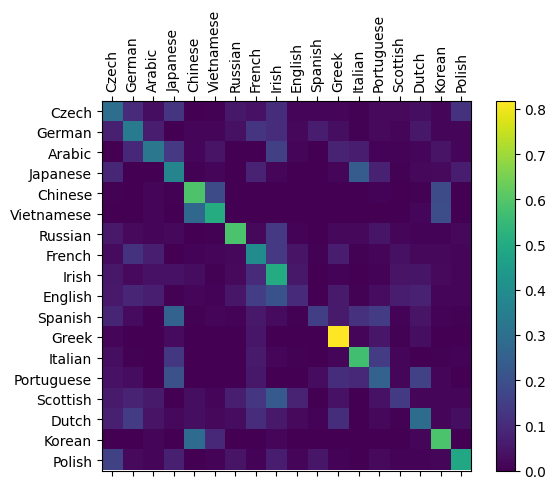


> Dostoevsky
(-1.14) Russian
(-1.65) Polish
(-1.77) Czech

> Jackson
(-1.31) Russian
(-1.68) Scottish
(-2.02) English

> Satoshi
(-0.70) Italian
(-1.52) Japanese
(-2.43) Arabic

> Bernal
(-1.86) Czech
(-1.87) Irish
(-2.21) German


In [9]:
#n_hidden is 2
n_hidden = 2
rnn = RNN(n_letters, n_hidden, n_categories)

# %% To run a step of this network we need to pass an input (in our case, the
# Tensor for the current letter) and a previous hidden state (which we
# initialize as zeros at first). We'll get back the output (probability of
# each language) and a next hidden state (which we keep for the next
# step).

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

# For the sake of efficiency we don't want to be creating a new Tensor for
# every step, so we will use ``nameToTensor`` instead of
# ``letterToTensor`` and use slices. This could be further optimized by
# pre-computing batches of Tensors.
# 

input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

# As you can see the output is a ``<1 x n_categories>`` Tensor, where
# every item is the likelihood of that category (higher is more likely).
# 

# %% Training
# ========
# Preparing for Training
# ----------------------
# 
# Before going into training we should make a few helper functions. The
# first is to interpret the output of the network, which we know to be a
# likelihood of each category. We can use ``Tensor.topk`` to get the index
# of the greatest value:
# 

def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

print(categoryFromOutput(output))

# We will also want a quick way to get a training example (a name and its
# language):
# 

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)

# %% Training the Network
# --------------------
# 
# Now all it takes to train the network is show it a bunch of examples,
# have it make guesses, and compare its output against labels.
# 
# For the loss function ``nn.NLLLoss`` is appropriate, since the last
# layer of the RNN is ``nn.LogSoftmax``.
# 
criterion = nn.NLLLoss()

# Each loop of training will:
# 
# -  Create input and target tensors
# -  Create a zeroed initial hidden state
# -  Read each letter in and
# 
#    -  Keep hidden state for next letter
# 
# -  Compare final output to target
# -  Back-propagate
# -  Return the output and loss
# 

learning_rate = 0.005 # For this example, we keep the learning rate fixed

def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

# Now we just have to run that with a bunch of examples. Since the
# ``train`` function returns both the output and loss we can print its
# guesses and also keep track of loss for plotting. Since there are 1000s
# of examples we print only every ``print_every`` examples, and take an
# average of the loss.
# 
n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


# Plotting the Results
# --------------------
# 
# Plotting the historical loss from ``all_losses`` shows the network
# learning:
#

plt.figure()
plt.plot(all_losses)


# Evaluating the Results
# ======================
# 
# To see how well the network performs on different categories, we will
# create a confusion matrix, indicating for every actual language (rows)
# which language the network guesses (columns). To calculate the confusion
# matrix a bunch of samples are run through the network with
# ``evaluate()``, which is the same as ``train()`` minus the backprop.
# 

# In[14]:

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 20000

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

# Go through the entire dataset and record predictions
for category in languages:
    for name in names[category]:
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1

# Calculate accuracy
accuracy = sum(confusion.diag()) / sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# # # Go through a bunch of examples and record which are correctly guessed
# for i in range(n_confusion):
#     category, name, category_tensor, name_tensor = randomTrainingExample()
#     output = evaluate(name_tensor)
#     guess, guess_i = categoryFromOutput(output)
#     category_i = languages.index(category)
#     confusion[category_i][guess_i] += 1
    
# accuracy = sum(confusion.diag())/sum(sum(confusion))
# print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

 
#You can pick out bright spots off the main axis that show which
# languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish
# for Italian. It seems to do very well with Greek, and very poorly with
# English (perhaps because of overlap with other languages).
# 

# CODE below is for illustration only
# Running on User Input
# ---------------------
# 


def predict(name, n_predictions=3):
    print('\n> %s' % name)
    with torch.no_grad():
        output = evaluate(nameToTensor(name))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, languages[category_index]))
            predictions.append([value, languages[category_index]])

findName(names,'Dostoevsky')
predict('Dostoevsky')
findName(names,'Jackson')
predict('Jackson')
findName(names,'Satoshi')
predict('Satoshi')
predict('Bernal')

tensor([[-2.8774, -2.6826, -3.0709, -2.8181, -2.7108, -2.8514, -2.8844, -2.9269,
         -3.0903, -2.9408, -2.9498, -2.8792, -2.9539, -2.7306, -2.9734, -3.0166,
         -2.8242, -2.9578]], grad_fn=<LogSoftmaxBackward0>)
('German', 1)
category = Polish / name = Smolak
category = Portuguese / name = Melo
category = Vietnamese / name = Giang
category = Czech / name = Markytan
category = Vietnamese / name = Chau
category = English / name = Down
category = Portuguese / name = Soares
category = Italian / name = Guttuso
category = English / name = Fagon
category = Czech / name = Krivan
5000 5% (0m 1s) 2.2890 Piskunov / Russian ✓
10000 10% (0m 2s) 2.1125 Sniegowski / Italian ✗ (Polish)
15000 15% (0m 3s) 2.8682 Nagase / French ✗ (Japanese)
20000 20% (0m 4s) 2.5397 Fournier / German ✗ (French)
25000 25% (0m 5s) 2.2776 Maalouf / Czech ✗ (Arabic)
30000 30% (0m 6s) 2.8333 Amador / Scottish ✗ (Spanish)
35000 35% (0m 7s) 0.8086 Huynh / Vietnamese ✓
40000 40% (0m 8s) 1.1840 Delgado / Portuguese ✓
45

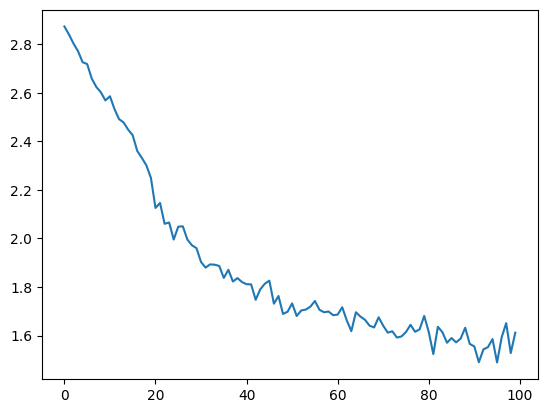

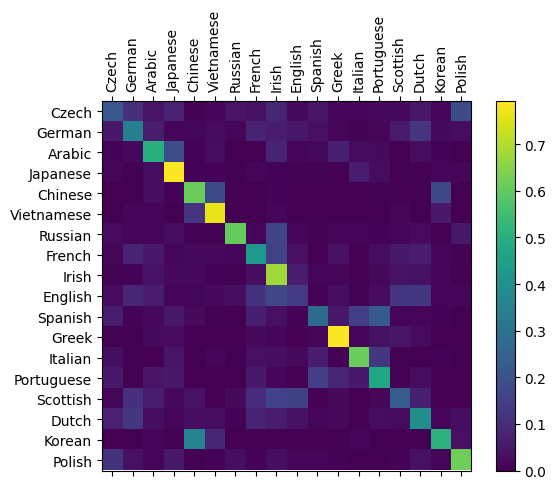


> Dostoevsky
(-0.39) Russian
(-2.35) Czech
(-2.49) Polish

> Jackson
(-1.26) Scottish
(-1.55) Polish
(-1.88) Russian

> Satoshi
(-0.30) Japanese
(-2.43) Italian
(-2.94) Polish

> Bernal
(-1.91) Czech
(-1.92) Scottish
(-2.10) English


In [10]:
# n_hidden is 8
n_hidden = 8
rnn = RNN(n_letters, n_hidden, n_categories)

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

print(categoryFromOutput(output))

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)

criterion = nn.NLLLoss()
 
learning_rate = 0.005 # For this example, we keep the learning rate fixed

def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


plt.figure()
plt.plot(all_losses)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 20000

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

# Go through the entire dataset and record predictions
for category in languages:
    for name in names[category]:
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1

# Calculate accuracy
accuracy = sum(confusion.diag()) / sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

def predict(name, n_predictions=3):
    print('\n> %s' % name)
    with torch.no_grad():
        output = evaluate(nameToTensor(name))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, languages[category_index]))
            predictions.append([value, languages[category_index]])

findName(names,'Dostoevsky')
predict('Dostoevsky')
findName(names,'Jackson')
predict('Jackson')
findName(names,'Satoshi')
predict('Satoshi')
predict('Bernal')


tensor([[-2.8886, -2.8550, -2.9676, -2.9763, -2.9529, -2.8823, -3.0332, -2.9008,
         -2.8710, -2.8605, -2.8689, -2.9348, -2.7478, -2.8564, -2.7918, -2.9379,
         -2.9951, -2.7584]], grad_fn=<LogSoftmaxBackward0>)
('Italian', 12)
category = Portuguese / name = Lobo
category = Portuguese / name = Santos
category = Italian / name = Lazzari
category = Russian / name = Iskos
category = Spanish / name = Basurto
category = Irish / name = Kavanagh
category = Czech / name = Koliha
category = German / name = Heinrich
category = Czech / name = Jares
category = Spanish / name = Arce
5000 5% (0m 1s) 2.7286 Seok / Polish ✗ (Korean)
10000 10% (0m 2s) 2.6177 Chi / Italian ✗ (Korean)
15000 15% (0m 3s) 2.2317 Chilar / Arabic ✗ (Czech)
20000 20% (0m 4s) 1.2313 Gagliardi / Italian ✓
25000 25% (0m 5s) 0.2344 Stamatelos / Greek ✓
30000 30% (0m 6s) 2.0109 Rheem / German ✗ (Korean)
35000 35% (0m 7s) 0.2304 Rudawski / Polish ✓
40000 40% (0m 8s) 0.9550 Xuan / Chinese ✓
45000 45% (0m 10s) 0.8091 Sam / C

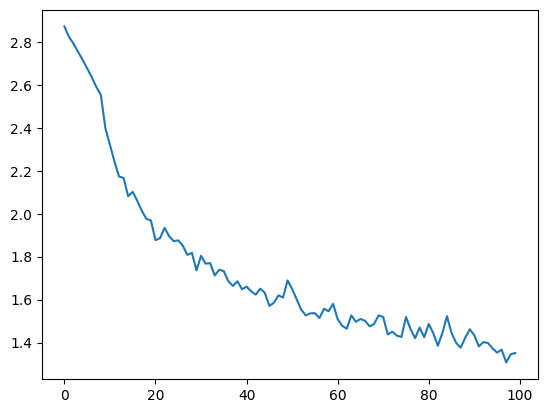

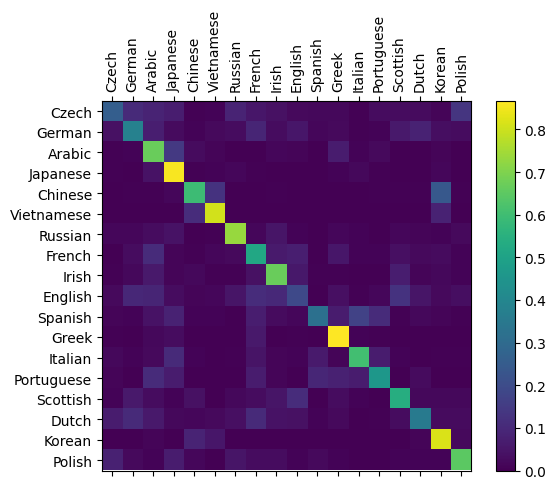


> Dostoevsky
(-0.18) Russian
(-2.42) Czech
(-3.41) English

> Jackson
(-0.58) Scottish
(-1.69) English
(-2.29) Russian

> Satoshi
(-0.82) Arabic
(-1.03) Japanese
(-2.58) Italian

> Bernal
(-1.04) Czech
(-1.55) Arabic
(-2.46) German


In [11]:
# n_hidden is 32
n_hidden = 32
rnn = RNN(n_letters, n_hidden, n_categories)

input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)
output, next_hidden = rnn(input, hidden)

input = nameToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

def categoryFromOutput(output):
    # compute max
    top_n, top_i = output.topk(1)
    # output index of max
    category_i = top_i.item()
    return languages[category_i], category_i

print(categoryFromOutput(output))

# We will also want a quick way to get a training example (a name and its
# language):
# 
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)

# 
criterion = nn.NLLLoss()

learning_rate = 0.005 # For this example, we keep the learning rate fixed

def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(all_losses)


# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 20000

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output

# Go through the entire dataset and record predictions
for category in languages:
    for name in names[category]:
        category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
        name_tensor = nameToTensor(name)
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1

# Calculate accuracy
accuracy = sum(confusion.diag()) / sum(sum(confusion))
print('Accuracy is %f' % accuracy.item())

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + languages, rotation=90)
ax.set_yticklabels([''] + languages)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

def predict(name, n_predictions=3):
    print('\n> %s' % name)
    with torch.no_grad():
        output = evaluate(nameToTensor(name))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, languages[category_index]))
            predictions.append([value, languages[category_index]])

findName(names,'Dostoevsky')
predict('Dostoevsky')
findName(names,'Jackson')
predict('Jackson')
findName(names,'Satoshi')
predict('Satoshi')
predict('Bernal')


**1.2.	(20 points)** Effect of systematic training - the script trains the network by going through 100 thousand data samples one by one in a random manner:

The network parameters are updated by backpropagating losses computed on a per-sample basis. Also note that the there is only 1 training epoch in the example provided. 

Modify the script so that, instead of picking each training sample randomly, it goes through every available sample exactly once per training epoch. Randomize the order of the samples within each epoch. Train the network for five epochs, and report results as you change the hidden state size as in Problem 1.1 above. Note that, since the dataset comprises around 20000 datapoints, the total number of data passes for this modified training process are like those required by Problem 1.1. 

What is the accuracy thus trained and evaluated for the different values of hidden state size (2,8,32)?  Also, include a graph of the loss function and the confusion matrix for each case. 

<br><font color='SlateBlue'>*With hidden state sizes 2, the accuracy is 43.95%. 
    <br>With hidden state sizes 8, the accuracy is 54.33%.
    <br>With hidden state sizes 32, the accuracy is 60.68%.*</font>

category = Scottish / name = Whyte
category = Russian / name = Batchish
category = Russian / name = Gruschak
category = Spanish / name = Tapia
category = German / name = Schuhmacher
category = Dutch / name = Meeuwes
category = Chinese / name = Chin
category = French / name = Herriot
category = French / name = Bernard
category = Portuguese / name = Ribeiro
5000 5% (0m 1s) 2.6105 Hung / Chinese ✗ (Korean)
10000 10% (0m 2s) 2.6978 Kalb / Vietnamese ✗ (Arabic)
15000 15% (0m 3s) 1.2292 Lieu / Vietnamese ✓
20000 20% (0m 4s) 1.5775 Kurofuji / Italian ✗ (Japanese)
25000 25% (0m 5s) 0.4792 Arrighetti / Italian ✓
30000 30% (0m 6s) 1.4173 O'Ryan / Irish ✓
35000 35% (0m 7s) 0.9951 Kurofuji / Japanese ✓
40000 40% (0m 8s) 0.6172 Bonnaire / French ✓
45000 45% (0m 9s) 0.9957 Mak / Vietnamese ✗ (Chinese)
50000 50% (0m 10s) 0.6863 Dovgaev / Russian ✓
55000 55% (0m 12s) 1.9608 Rice / French ✗ (English)
60000 60% (0m 13s) 1.9321 Mooney / English ✗ (Irish)
65000 65% (0m 14s) 0.0827 Horoshavtsev / Russian ✓

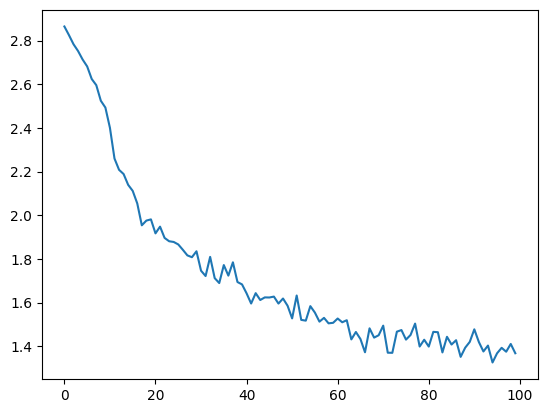

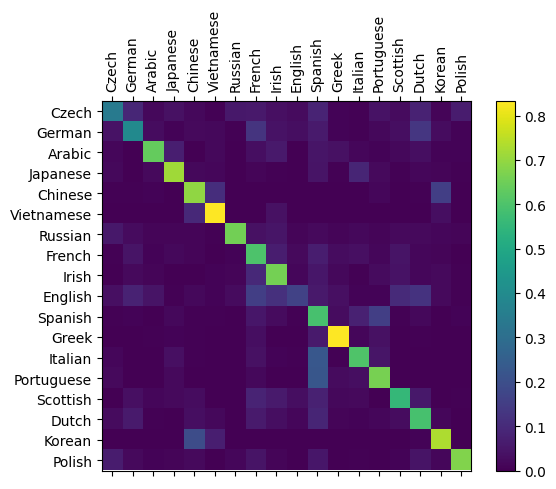

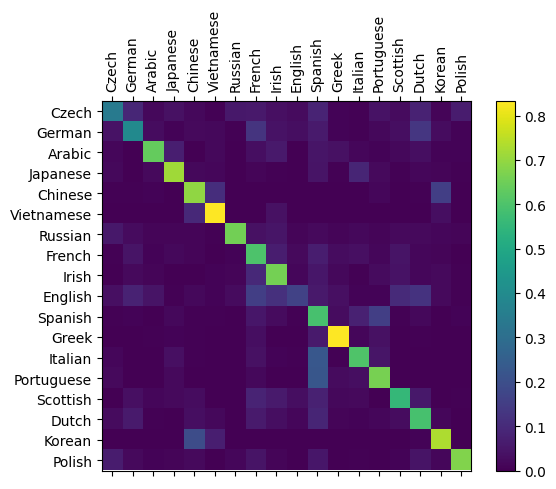

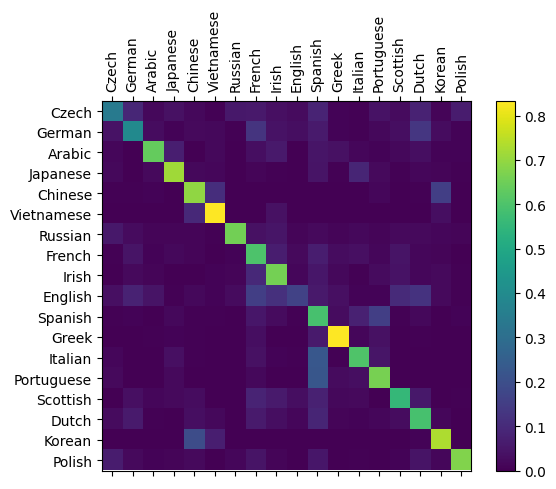


> Dostoevsky
(-0.11) Russian
(-2.92) Czech
(-3.60) English

> Jackson
(-0.35) Scottish
(-2.12) English
(-2.44) Dutch

> Satoshi
(-0.35) Italian
(-3.03) Japanese
(-3.04) Greek

> Bernal
(-1.35) Czech
(-1.80) French
(-1.89) German


In [13]:

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(languages)
    name = randomChoice(names[category])
    category_tensor = torch.tensor([languages.index(category)], dtype=torch.long)
    name_tensor = nameToTensor(name)
    return category, name, category_tensor, name_tensor

for i in range(10):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    print('category =', category, '/ name =', name)
    
# Function to get all training examples
def getAllTrainingExamples():
    examples = []
    for _ in range(n_iters):
        category, name, category_tensor, name_tensor = randomTrainingExample()
        examples.append((category_tensor, name_tensor))
    return examples

 
criterion = nn.NLLLoss()

learning_rate = 0.005 # For this example, we keep the learning rate fixed


def train(category_tensor, name_tensor):
    # initialize hidden state - do this every time before passing an input sequence
    hidden = rnn.initHidden()
    # reset grad counters - do this every time after backprop
    rnn.zero_grad()
    # manually go through each element in input sequence
    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    # backpropagate based on loss at last element only
    loss = criterion(output, category_tensor)
    loss.backward()

    # Update network parameters
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of loss for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, name, category_tensor, name_tensor = randomTrainingExample()
    output, loss = train(category_tensor, name_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, 
                                                timeSince(start), loss, name, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(all_losses)

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 20000

# return an output given an input name
def evaluate(name_tensor):
    hidden = rnn.initHidden()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)

    return output


n_epochs = 5

# Initialize the RNN with different hidden sizes
hidden_state_sizes = [2, 8, 32]
results = {}

for hidden_size in hidden_state_sizes:
    rnn = RNN(n_letters, hidden_size, n_categories)
    criterion = nn.NLLLoss()
    current_loss = 0
    all_losses = []

    # Training loop
    for epoch in range(n_epochs):
        all_examples = getAllTrainingExamples()
        random.shuffle(all_examples)

        for example in all_examples:
            category_tensor, name_tensor = example
            output, loss = train(category_tensor, name_tensor)
            current_loss += loss

        if epoch % print_every == 0:
            print('Epoch: %d, Loss: %.4f' % (epoch, current_loss / n_iters))

        if epoch % plot_every == 0:
            all_losses.append(current_loss / plot_every)
            current_loss = 0

    # Evaluate accuracy, confusion matrix, and plot the loss
    confusion = torch.zeros(n_categories, n_categories)
    n_confusion = 20000

    for i in range(n_confusion):
        category, name, category_tensor, name_tensor = randomTrainingExample()
        output = evaluate(name_tensor)
        guess, guess_i = categoryFromOutput(output)
        category_i = languages.index(category)
        confusion[category_i][guess_i] += 1

    accuracy = sum(confusion.diag()) / sum(sum(confusion))
    print('Accuracy for hidden size %d: %f' % (hidden_size, accuracy.item()))

    results[hidden_size] = {
        'accuracy': accuracy.item(),
        'confusion_matrix': confusion.clone().numpy(),
        'loss': all_losses.copy(),
    }
    # Normalize by dividing every row by its sum
    for i in range(n_categories):
        confusion[i] = confusion[i] / confusion[i].sum()

    
for hidden_size in hidden_state_sizes:
    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + languages, rotation=90)
    ax.set_yticklabels([''] + languages)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
plt.show()
 
def predict(name, n_predictions=3):
    print('\n> %s' % name)
    with torch.no_grad():
        output = evaluate(nameToTensor(name))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, languages[category_index]))
            predictions.append([value, languages[category_index]])

findName(names,'Dostoevsky')
predict('Dostoevsky')
findName(names,'Jackson')
predict('Jackson')
findName(names,'Satoshi')
predict('Satoshi')
predict('Bernal')


# 2.	Batch training of data

The training process in Problem 1 above is still suboptimal since the gradient estimates are computed on a sample-by-sample basis (i.e., a batch size of 1). In this question, you are exposed to batch processing.
For this question, you can use the code sample “char_rnn_classification_Project3p1_Q2.py” which provides you an outline of how the code can be structured to meet the goals of this question. Of course, you are welcome to create your own custom code from scratch!

**2.1.	(25 points)** Modify the implementation of the network to leverage the RNN subclass of module torch.nn, which readily incorporates support for batch training. Note that the “nn.RNN” class is modified to operate in a batch mode.
Set the hidden state size to 128 and train the network through five epochs with a batch size equal to the total number of samples. Note that, since the data samples are of different lengths, you will need to pad the length of the samples to a unique sequence length (e.g., at least the length of the longest sequence) in order to be able to feed the batch to the network.
This is because RNN expects the input to be a tensor of shape (batch, seq_len, input_size). It is best to manually pad with 0s, or you can use built-in functions such as torch.nn.utils.rnn.pad_sequence to perform the padding. 

Report the accuracy yielded by this approach on the full training set after training for 5 epochs.
<br>Recall that input_size refers to the size of the features (in this case one-hot encoded representation of each letter). Hidden size is a hyper parameter you can adjust (we will keep it fixed at 128 in this question). The comments in the code above explain how to format your batch data, depending on the value of batch_first. Lastly, OUTPUT_SIZE denotes the number of classes.

<br><font color='SlateBlue'>*Epoch:  1 | accuracy: 72.80%
<br>Epoch:  2 | accuracy: 71.85%
<br>Epoch:  3 | accuracy: 72.56%
<br>Epoch:  4 | accuracy: 71.62%
<br>Epoch:  5 | accuracy: 70.66%*</font>

In [14]:
class RNN(nn.Module):
    def __init__(self, INPUT_SIZE, HIDDEN_SIZE, N_LAYERS, OUTPUT_SIZE):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE,
            hidden_size=HIDDEN_SIZE,
            num_layers=N_LAYERS,
            batch_first=True
        )
        self.out = nn.Linear(HIDDEN_SIZE, OUTPUT_SIZE)
            
    def forward(self, x):
        r_out, h = self.rnn(x, None)
        out = self.out(r_out[:, -1, :])
        return out

def categoryFromOutput(output):
    _, category_i = output.max(1)
    return category_i.item()

In [15]:
n_hidden = 128

allnames = [] # Create list of all names and corresponding output language
for language in list(names.keys()):
    for name in names[language]:
        allnames.append([name, language])
        
## (TO DO:) Determine Padding length (this is the length of the longest string) 

# maxlen = ..... # Add code here to compute the maximum length of string 

# Determine the maximum length of the names
maxlen = max(len(name) for name, _ in allnames)

# # Pad the names to the maximum length
# padded_names = [(name.ljust(maxlen), lang) for name, lang in allnames]

                
n_letters = len(all_letters)
n_categories = len(languages)
           
# Experiment with different hyperparameters
learning_rate = 0.001
rnn = RNN(n_letters, 128, 2, n_categories)  # Increase the number of layers
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

for epoch in range(5):
    random.shuffle(allnames)
    
    for i, (name, language) in enumerate(allnames):
        # Padding and one-hot encoding
        b_in = torch.zeros(1, len(name), n_letters)
        for j, letter in enumerate(name):
            b_in[0, j, letterToIndex(letter)] = 1

        b_out = torch.tensor([languages.index(language)], dtype=torch.long)

        output = rnn(b_in)
        loss = loss_func(output, b_out)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print accuracy
    total_correct = 0
    for name, language in allnames:
        b_in = torch.zeros(1, len(name), n_letters)
        for j, letter in enumerate(name):
            b_in[0, j, letterToIndex(letter)] = 1

        output = rnn(b_in)
        predicted_language = languages[categoryFromOutput(output)]
        if predicted_language == language:
            total_correct += 1

    accuracy = total_correct / len(allnames)
    print("Epoch: ", epoch, "| train loss: %.4f" % loss.item(), '| accuracy: %.4f' % accuracy)

Epoch:  0 | train loss: 0.4106 | accuracy: 0.7280
Epoch:  1 | train loss: 0.0044 | accuracy: 0.7185
Epoch:  2 | train loss: 0.1599 | accuracy: 0.7256
Epoch:  3 | train loss: 0.3408 | accuracy: 0.7162
Epoch:  4 | train loss: 0.0337 | accuracy: 0.7066


**2.2.	(10 points)** Modify the implementation from 2.1 to support arbitrary mini-batch sizes.
In this case, instead of padding to a unique sequence length, adaptively pad the length of the mini batch to the length of the longest sample in the mini batch itself. Report the accuracy number (on the full training set) yielded by this approach on mini batch sizes of 1000, 2000, 3000 after five epochs of training.

Note that since these problems only ask you to train for five epochs it won’t be graded based on performance (unless you get significantly smaller numbers than what’s reasonable for five epochs of training).

<br><font color='SlateBlue'>*Epoch:  1 | Mini-batch size:  1000 | accuracy: 0.7098
<br>Epoch:  2 | Mini-batch size:  1000 | accuracy: 73.05%
<br>Epoch:  3 | Mini-batch size:  1000 | accuracy: 71.63%
<br>Epoch:  4 | Mini-batch size:  1000 | accuracy: 71.20%
<br>Epoch:  5 | Mini-batch size:  1000 | accuracy: 70.34%
<br>Epoch:  1 | Mini-batch size:  2000 | accuracy: 70.26%
<br>Epoch:  2 | Mini-batch size:  2000 | accuracy: 70.75%
<br>Epoch:  3 | Mini-batch size:  2000 | accuracy: 70.27%
<br>Epoch:  4 | Mini-batch size:  2000 | accuracy: 69.94%
<br>Epoch:  5 | Mini-batch size:  2000 | accuracy: 69.35%
<br>Epoch:  1 | Mini-batch size:  3000 | accuracy: 65.85%
<br>Epoch:  2 | Mini-batch size:  3000 | accuracy: 66.51%
<br>Epoch:  3 | Mini-batch size:  3000 | accuracy: 67.39%
<br>Epoch:  4 | Mini-batch size:  3000 | accuracy: 66.34%
<br>Epoch:  5 | Mini-batch size:  3000 | accuracy: 65.61%*</font>

In [16]:
n_hidden = 128

allnames = [] # Create list of all names and corresponding output language
for language in list(names.keys()):
    for name in names[language]:
        allnames.append([name, language])
        
# Determine the maximum length of the names
maxlen = max(len(name) for name, _ in allnames)

# # Pad the names to the maximum length
padded_names = [(name.ljust(maxlen), lang) for name, lang in allnames]
#print(padded_names)
                
n_letters = len(all_letters)
n_categories = len(languages)
           
# Experiment with different hyperparameters
learning_rate = 0.001
rnn = RNN(n_letters, 128, 2, n_categories)  # Increase the number of layers
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

batch_sizes = [1000, 2000, 3000]

for batch_size in batch_sizes:
    for epoch in range(5):
        random.shuffle(allnames)
        
        for i, (name, language) in enumerate(allnames):
            # Padding and one-hot encoding
            b_in = torch.zeros(1, len(name), n_letters)
            for j, letter in enumerate(name):
                b_in[0, j, letterToIndex(letter)] = 1

            b_out = torch.tensor([languages.index(language)], dtype=torch.long)

            output = rnn(b_in)
            loss = loss_func(output, b_out)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        #we do ephoch and then change the batch size and we should use the whole dataset in the batch mode

        # Print accuracy
        total_correct = 0
        #dataloader = DataLoader(allnames, batch_size=batch_size, shuffle=False)
    
        for name, language in allnames:
            b_in = torch.zeros(1, len(name), n_letters)
            for j, letter in enumerate(name):
                b_in[0, j, letterToIndex(letter)] = 1

            output = rnn(b_in)
            predicted_language = languages[categoryFromOutput(output)]
            if predicted_language == language:
                total_correct += 1

        accuracy = total_correct / len(allnames)
        print("Epoch: ", epoch, "| Mini-batch size: ", batch_size, '| accuracy: %.4f' % accuracy)

Epoch:  0 | Mini-batch size:  1000 | accuracy: 0.7098
Epoch:  1 | Mini-batch size:  1000 | accuracy: 0.7305
Epoch:  2 | Mini-batch size:  1000 | accuracy: 0.7163
Epoch:  3 | Mini-batch size:  1000 | accuracy: 0.7120
Epoch:  4 | Mini-batch size:  1000 | accuracy: 0.7034
Epoch:  0 | Mini-batch size:  2000 | accuracy: 0.7026
Epoch:  1 | Mini-batch size:  2000 | accuracy: 0.7075
Epoch:  2 | Mini-batch size:  2000 | accuracy: 0.7027
Epoch:  3 | Mini-batch size:  2000 | accuracy: 0.6994
Epoch:  4 | Mini-batch size:  2000 | accuracy: 0.6935
Epoch:  0 | Mini-batch size:  3000 | accuracy: 0.6585
Epoch:  1 | Mini-batch size:  3000 | accuracy: 0.6651
Epoch:  2 | Mini-batch size:  3000 | accuracy: 0.6739
Epoch:  3 | Mini-batch size:  3000 | accuracy: 0.6634
Epoch:  4 | Mini-batch size:  3000 | accuracy: 0.6561
